<a href="https://colab.research.google.com/github/TimTree/DS-Unit-2-Regression-Classification/blob/master/module1/assignment_kaggle_challenge_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Lambda School Data Science, Unit 2: Predictive Modeling

# Kaggle Challenge, Module 1

## Assignment
- [x] Do train/validate/test split with the Tanzania Waterpumps data.
- [ ] Define a function to wrangle train, validate, and test sets in the same way. Clean outliers and engineer features. (For example, [what other columns have zeros and shouldn't?](https://github.com/Quartz/bad-data-guide#zeros-replace-missing-values) What other columns are duplicates, or nearly duplicates? Can you extract the year from date_recorded? Can you engineer new features, such as the number of years from waterpump construction to waterpump inspection?)
- [ ] Select features. Use a scikit-learn pipeline to encode categoricals, impute missing values, and fit a decision tree classifier.
- [ ] Get your validation accuracy score.
- [ ] Get and plot your feature importances.
- [ ] Submit your predictions to our Kaggle competition. (Go to our Kaggle InClass competition webpage. Use the blue **Submit Predictions** button to upload your CSV file. Or you can use the Kaggle API to submit your predictions.)
- [ ] Commit your notebook to your fork of the GitHub repo.


## Stretch Goals

### Reading

- A Visual Introduction to Machine Learning
  - [Part 1: A Decision Tree](http://www.r2d3.us/visual-intro-to-machine-learning-part-1/)
  - [Part 2: Bias and Variance](http://www.r2d3.us/visual-intro-to-machine-learning-part-2/)
- [Decision Trees: Advantages & Disadvantages](https://christophm.github.io/interpretable-ml-book/tree.html#advantages-2)
- [How a Russian mathematician constructed a decision tree — by hand — to solve a medical problem](http://fastml.com/how-a-russian-mathematician-constructed-a-decision-tree-by-hand-to-solve-a-medical-problem/)
- [How decision trees work](https://brohrer.github.io/how_decision_trees_work.html)
- [Let’s Write a Decision Tree Classifier from Scratch](https://www.youtube.com/watch?v=LDRbO9a6XPU) — _Don’t worry about understanding the code, just get introduced to the concepts. This 10 minute video has excellent diagrams and explanations._
- [Random Forests for Complete Beginners: The definitive guide to Random Forests and Decision Trees](https://victorzhou.com/blog/intro-to-random-forests/)


### Doing
- [ ] Add your own stretch goal(s) !
- [ ] Try other [scikit-learn imputers](https://scikit-learn.org/stable/modules/impute.html).
- [ ] Make exploratory visualizations and share on Slack.


#### Exploratory visualizations

Visualize the relationships between feature(s) and target. I recommend you do this with your training set, after splitting your data. 

For this problem, you may want to create a new column to represent the target as a number, 0 or 1. For example:

```python
train['functional'] = (train['status_group']=='functional').astype(int)
```



You can try [Seaborn "Categorical estimate" plots](https://seaborn.pydata.org/tutorial/categorical.html) for features with reasonably few unique values. (With too many unique values, the plot is unreadable.)

- Categorical features. (If there are too many unique values, you can replace less frequent values with "OTHER.")
- Numeric features. (If there are too many unique values, you can [bin with pandas cut / qcut functions](https://pandas.pydata.org/pandas-docs/stable/getting_started/basics.html?highlight=qcut#discretization-and-quantiling).)

You can try [Seaborn linear model plots](https://seaborn.pydata.org/tutorial/regression.html) with numeric features. For this classification problem, you may want to use the parameter `logistic=True`, but it can be slow.

You do _not_ need to use Seaborn, but it's nice because it includes confidence intervals to visualize uncertainty.

#### High-cardinality categoricals

This code from a previous assignment demonstrates how to replace less frequent values with 'OTHER'

```python
# Reduce cardinality for NEIGHBORHOOD feature ...

# Get a list of the top 10 neighborhoods
top10 = train['NEIGHBORHOOD'].value_counts()[:10].index

# At locations where the neighborhood is NOT in the top 10,
# replace the neighborhood with 'OTHER'
train.loc[~train['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
test.loc[~test['NEIGHBORHOOD'].isin(top10), 'NEIGHBORHOOD'] = 'OTHER'
```


In [1]:
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '../data/'

In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split

train = pd.merge(pd.read_csv(DATA_PATH+'waterpumps/train_features.csv'), 
                 pd.read_csv(DATA_PATH+'waterpumps/train_labels.csv'))
test = pd.read_csv(DATA_PATH+'waterpumps/test_features.csv')
sample_submission = pd.read_csv(DATA_PATH+'waterpumps/sample_submission.csv')

train.shape, test.shape

((59400, 41), (14358, 40))

In [3]:
test.head()

,id,amount_tsh,date_recorded,funder,gps_height,installer,longitude,latitude,wpt_name,num_private,basin,subvillage,region,region_code,district_code,lga,ward,population,public_meeting,recorded_by,scheme_management,scheme_name,permit,construction_year,extraction_type,extraction_type_group,extraction_type_class,management,management_group,payment,payment_type,water_quality,quality_group,quantity,quantity_group,source,source_type,source_class,waterpoint_type,waterpoint_type_group
0,50785,0.0,2013-02-04,Dmdd,1996,DMDD,35.290799,-4.059696,Dinamu Secondary School,0,Internal,Magoma,Manyara,21,3,Mbulu,Bashay,321,True,GeoData Consultants Ltd,Parastatal,NaN,True,2012,other,other,other,parastatal,parastatal,never pay,never pay,soft,good,seasonal,seasonal,rainwater harvesting,rainwater harvesting,surface,other,other
1,51630,0.0,2013-02-04,Government Of Tanzania,1569,DWE,36.656709,-3.309214,Kimnyak,0,Pangani,Kimnyak,Arusha,2,2,Arusha Rural,Kimnyaki,300,True,GeoData Consultants Ltd,VWC,TPRI pipe line,True,2000,gravity,gravity,gravity,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,spring,spring,groundwater,communal standpipe,communal standpipe
2,17168,0.0,2013-02-01,NaN,1567,NaN,34.767863,-5.004344,Puma Secondary,0,Internal,Msatu,Singida,13,2,Singida Rural,Puma,500,True,GeoData Consultants Ltd,VWC,P,NaN,2010,other,other,other,vwc,user-group,never pay,never pay,soft,good,insufficient,insufficient,rainwater harvesting,rainwater harvesting,surface,other,other
3,45559,0.0,2013-01-22,Finn Water,267,FINN WATER,38.058046,-9.418672,Kwa Mzee Pange,0,Ruvuma / Southern Coast,Kipindimbi,Lindi,80,43,Liwale,Mkutano,250,NaN,GeoData Consultants Ltd,VWC,NaN,True,1987,other,other,other,vwc,user-group,unknown,unknown,soft,good,dry,dry,shallow well,shallow well,groundwater,other,other
4,49871,500.0,2013-03-27,Bruder,1260,BRUDER,35.006123,-10.950412,Kwa Mzee Turuka,0,Ruvuma / Southern Coast,Losonga,Ruvuma,10,3,Mbinga,Mbinga Urban,60,NaN,GeoData Consultants Ltd,Water Board,BRUDER,True,2000,gravity,gravity,gravity,water board,user-group,pay monthly,monthly,soft,good,enough,enough,spring,spring,groundwater,communal standpipe,communal standpipe


### Do train/validate/test split

In [0]:
train, validate = train_test_split(train, random_state=84)

In [5]:
train.shape, validate.shape, 

((44550, 41), (14850, 41))

### Wrangling data

In [6]:
train.describe()

,id,amount_tsh,gps_height,longitude,latitude,num_private,region_code,district_code,population,construction_year
count,44550.000000,44550.000000,44550.000000,44550.000000,4.455000e+04,44550.000000,44550.000000,44550.000000,44550.000000,44550.000000
mean,37125.305230,313.072938,670.609921,34.092049,-5.716952e+00,0.523793,15.307901,5.611044,179.278316,1302.449001
std,21414.489668,3132.801614,693.532046,6.532939,2.946552e+00,13.504086,17.626144,9.587356,475.347235,951.066154
min,0.000000,0.000000,-90.000000,0.000000,-1.164944e+01,0.000000,1.000000,0.000000,0.000000,0.000000
25%,18565.250000,0.000000,0.000000,33.091840,-8.552864e+00,0.000000,5.000000,2.000000,0.000000,0.000000
50%,37075.000000,0.000000,374.000000,34.914659,-5.038869e+00,0.000000,12.000000,3.000000,25.000000,1986.000000
75%,55614.750000,20.000000,1322.000000,37.170795,-3.328204e+00,0.000000,17.000000,5.000000,215.000000,2004.000000
max,74246.000000,350000.000000,2628.000000,40.345193,-2.000000e-08,1776.000000,99.000000,80.000000,30500.000000,2013.000000


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4dec0018d0>]],
      dtype=object)

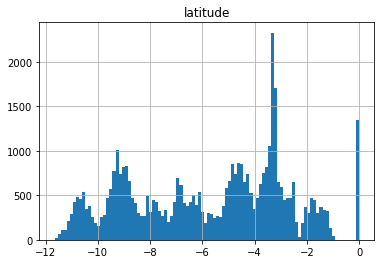

In [7]:
train.hist('latitude',bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4debea8c88>]],
      dtype=object)

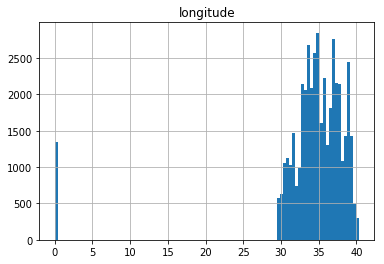

In [8]:
train.hist('longitude',bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4de9553208>]],
      dtype=object)

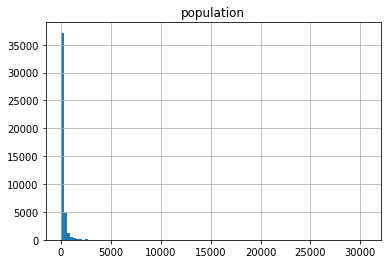

In [9]:
train.hist('population',bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4de9359a58>]],
      dtype=object)

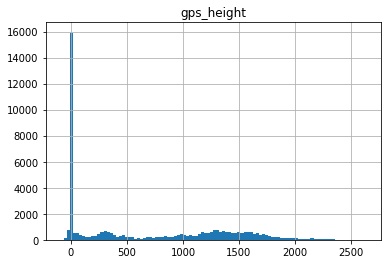

In [10]:
train.hist('gps_height',bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4de937d978>]],
      dtype=object)

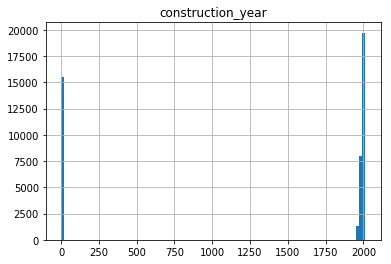

In [11]:
train.hist('construction_year',bins=100)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4de928e518>]],
      dtype=object)

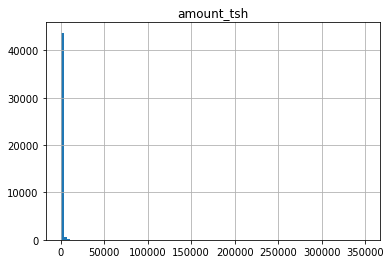

In [12]:
train.hist('amount_tsh',bins=100)

In [0]:
import numpy as np

def wrangle(X):
  # Wrangle the train, validate, and test datasets in one function

  # Prevent SettingWithCopyWarning
  X = X.copy()

  # About 3% of the time, latitude has small values near zero,
  # outside Tanzania, so we'll treat these values like zero.
  X['latitude'] = X['latitude'].replace(-2e-08, 0)

  # There are some values labeled as 0 that should be null values
  # (ex: Construction year can't realistically be 0). Let's convet
  # such values into nulls.
  cols_with_zeros = ['longitude', 'latitude', 'construction_year','population']
  for col in cols_with_zeros:
    X[col] = X[col].replace(0, np.nan)
  
  # quantity & quantity_group are duplicates, so drop one
  X = X.drop(columns='quantity_group')

  # Generate column that gives time difference from construction to inspection
  X['construction_to_inspection'] = pd.to_datetime(X['date_recorded']).dt.year - X['construction_year']
  
  # return the wrangled dataframe
  return X

In [0]:
train = wrangle(train)
validate = wrangle(validate)
test = wrangle(test)

In [15]:
train.dtypes

id                              int64
amount_tsh                    float64
date_recorded                  object
funder                         object
gps_height                      int64
installer                      object
longitude                     float64
latitude                      float64
wpt_name                       object
num_private                     int64
basin                          object
subvillage                     object
region                         object
region_code                     int64
district_code                   int64
lga                            object
ward                           object
population                    float64
public_meeting                 object
recorded_by                    object
scheme_management              object
scheme_name                    object
permit                         object
construction_year             float64
extraction_type                object
extraction_type_group          object
extraction_t

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f4de8f89208>]],
      dtype=object)

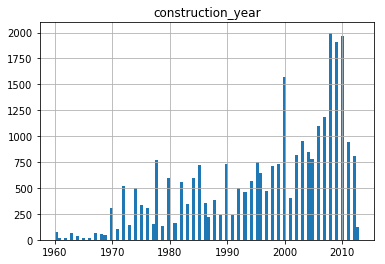

In [16]:
train.hist('construction_year',bins=100)

In [17]:
import plotly.express as px
px.scatter(train, x='longitude', y='latitude', color='status_group', opacity=0.1)

### Setting Features

In [18]:
# The target is the the status group
target = 'status_group'

# There's a lot of features here, numeric and categorical.

# Begin by getting all the features that are not the ID or status_group
train_features = train.drop(columns=[target,'id'])

# Let's take in all the numeric features, which is the all of them minus
# the target (and id in this case).
numerics = train_features.select_dtypes(include='number').columns.tolist()

# And here's all the categorical features
categoricals = train_features.select_dtypes(exclude='number').columns.tolist()

# Some categorical variables may have a ton of unique values. Not only will
# so many unique values make our model difficult to generalize, we'll overflow
# our computer's RAM if we did a one-hot encode of them (will explain one-hot
# encode shortly)
# So let's only accept low cardinality categoricals to analyze (that is, in
# this case, the categorical variables with 21 or less unique values.)
low_cardinality_categoricals = [col for col in categoricals
                               if train_features[col].nunique() <= 21]

# Now here are our features.
features = numerics + low_cardinality_categoricals
print(features)

['amount_tsh', 'gps_height', 'longitude', 'latitude', 'num_private', 'region_code', 'district_code', 'population', 'construction_year', 'construction_to_inspection', 'basin', 'region', 'public_meeting', 'recorded_by', 'scheme_management', 'permit', 'extraction_type', 'extraction_type_group', 'extraction_type_class', 'management', 'management_group', 'payment', 'payment_type', 'water_quality', 'quality_group', 'quantity', 'source', 'source_type', 'source_class', 'waterpoint_type', 'waterpoint_type_group']


In [0]:
X_train = train[features]
y_train = train[target]
X_validate = validate[features]
y_validate = validate[target]
X_test = test[features]

### Creating the pipeline

In [26]:
import category_encoders as ce
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import f_regression, SelectKBest, f_classif
from sklearn.tree import DecisionTreeClassifier

pipeline = make_pipeline(
    ce.OneHotEncoder(use_cat_names=True), 
    SimpleImputer(strategy='mean'), 
    StandardScaler(),
    DecisionTreeClassifier(max_depth=20, random_state=3432)
)

# Fit on train
pipeline.fit(X_train, y_train)

# Score on val
print('Validation Accuracy', pipeline.score(X_validate, y_validate))

# Predict on test
y_pred = pipeline.predict(X_test)

Validation Accuracy 0.7728619528619529


### Creating Kaggle Submission

In [27]:
submission = test[['id']].copy()
submission['status_group'] = y_pred
submission.head()

,id,status_group
0,50785,non functional
1,51630,non functional
2,17168,functional
3,45559,non functional
4,49871,functional


In [0]:
submission.to_csv('kaggleChallenge.csv', index=False)